# Introduction: Transfer Learning in PyTorch

In this notebook, we'll see how to use PyTorch to train a classifier to identify 101 different objects in images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch, convolutional neural networks, and inference. 

## Dataset: CalTech 101

The dataset is the [CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) of images from 101 categories. There are about 40 to 800 images in each category. I've reduced the number of categories to 100 and arranged them in three sets: train, valid, test with a split of 50%, 25%, and 25%. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
torch.cuda.is_available()
torch.cuda.memory_allocated()

True

0

### Parameters

The parameters in this cell can be changed as needed. I'm going to be training with 2 gpus in parallel, but your setup will probably be different. One of the benefits of using PyTorch is we can easily move different elements of the model or data to cpus/gpus or to multiple gpus. Granted, we probably won't always have many gpus, but when we do, we want to make the best use of them! 

In [3]:
PANOS = False
IMG_SIZE = 224

In [4]:
# loading the data
from load_data import train_test_set_loader
# make datasets
train_test_set_loader(path="../output/", test_size=0.1, val_size=0.1 ,example=False, panos=PANOS)

Number of training images: 6420
Number of test images: 803
Number of validation images: 803
Images have been split into train, test, and validation sets.


In [5]:
# Location of data
datadir = ''
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'

save_file_name = 'vit-transfer-4.pt'
checkpoint_path = 'vit-transfer-4.pth'

# Change to fit hardware
batch_size = 15

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [6]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df

,category,n_train,n_valid,n_test
1,london,1636,190,198
2,madrid,1601,194,205
3,moscow,1600,202,200
0,copenhagen,1583,217,200


In [7]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [8]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(),
        # transforms.RandomHorizontalFlip(),
        # # transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5015, 0.5156, 0.5024],
                             std=[0.2059, 0.2057, 0.2390])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5015, 0.5156, 0.5024],
                             std=[0.2059, 0.2057, 0.2390])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5015, 0.5156, 0.5024],
                             std=[0.2059, 0.2057, 0.2390])
    ]),
}

In [9]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [10]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [11]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([15, 3, 224, 224]), torch.Size([15]))

The shape of a batch is `(batch_size, color_channels, height, width)`. 

There should be 100 different classes. We can confirm this as follows.

In [12]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 4 different classes.


4

In [13]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

We can see that the model is quite large and training all of the layers would take a considerable time. Even with only a few layers to train, this can still take a while to train. You might need to decrease the `batch_size` if this is not fitting on your gpu (hopefully you have one).

In [14]:
if train_on_gpu:
    print("using gpu")
    model = model.to('cuda')

using gpu


#### Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [15]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'copenhagen'), (1, 'london'), (2, 'madrid'), (3, 'moscow')]

# Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient). 

* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients 

In [16]:
# criterion = nn.NLLLoss() # for vgg16 (has logsoftmax activation function)
criterion = nn.CrossEntropyLoss() # for ViT
optimizer = optim.AdamW(model.parameters()) # for ViT

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [17]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([768, 3, 16, 16])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([

# Training

For training, we iterate through the train `DataLoader`, each time passing one batch through the model. One complete pass through the training data is known as an `epoch`, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with `criterion(output, targets)`) and then calculate the gradients of the loss with respect to the model parameters with `loss.backward()`. This uses autodifferentiation and backpropagation to calculate the gradients. 

After calculating the gradients, we call `optimizer.step()` to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.


## Early Stopping

Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.

Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters. 

### Training Function

The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set. There are a number of parameters that I've tried to explain in the doc string. Hopefully, the comments and background make things somewhat understandable! 

In [18]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            logits = output.logits
            
            # Loss and backpropagation of gradients
            loss = criterion(logits, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(logits, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)
                    logits = output.logits

                    # Validation loss
                    loss = criterion(logits, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(logits, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [20]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=20,
    print_every=2)

Model has been trained for: 2 epochs.

Epoch: 1	100.00% complete. 153.57 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.0725 	Validation Loss: 1.0803
		Training Accuracy: 54.94%	 Validation Accuracy: 53.18%
Epoch: 3	100.00% complete. 153.80 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.0153 	Validation Loss: 1.0772
		Training Accuracy: 57.24%	 Validation Accuracy: 53.30%
Epoch: 5	100.00% complete. 153.56 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.0134 	Validation Loss: 1.1075
		Training Accuracy: 57.73%	 Validation Accuracy: 52.05%
Epoch: 7	100.00% complete. 154.34 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.9072 	Validation Loss: 1.0658
		Training Accuracy: 63.10%	 Validation Accuracy: 55.17%
Epoch: 9	100.00% complete. 154.13 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.8565 	Validation Loss: 1.2007
		Training Accuracy: 65.55%	 Validation Accuracy: 49.81%
Epoch: 11	100.00% complete. 154.33 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.77

# Training Results

We can inspect the training progress by looking at the `history`. 

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

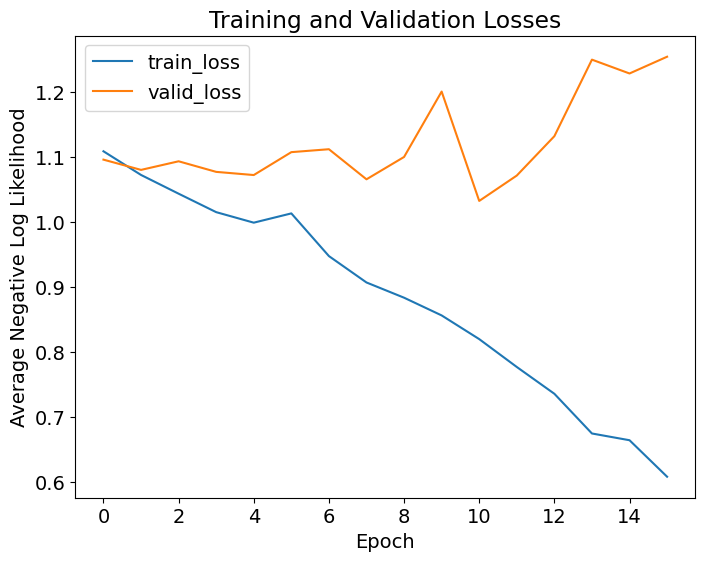

In [21]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss stops decreasing. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

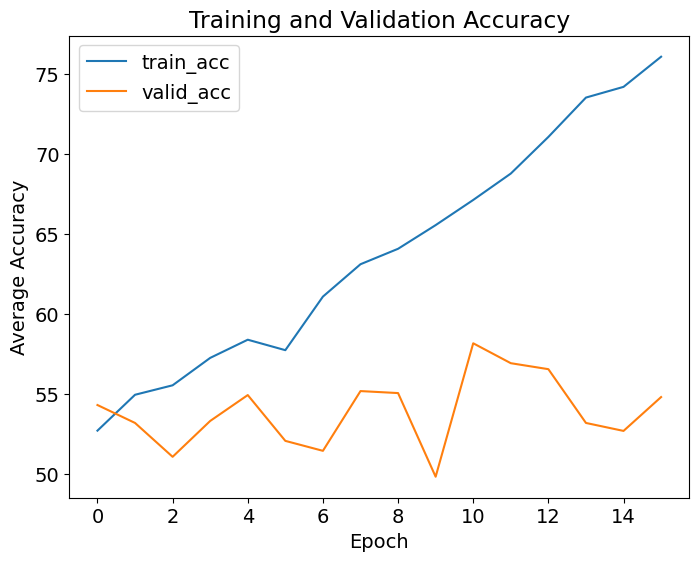

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 80% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

# Saving Model

The `train` function saves the best model `state_dict()` which are the weights of the model. To save more information about the model, we use the below function. 

In [70]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [71]:
save_checkpoint(model, path=checkpoint_path)

## Load in a Checkpoint

Now we need to write the function to load in the checkpoint. This just takes in a `path` and returns a model from a saved checkpoint.

In [72]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [73]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 256, 256), batch_size=batch_size)
else:
    summary(model, input_size=(3, 256, 256), batch_size=batch_size)

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


135,310,404 total parameters.
1,049,860 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


We can now use these two functions to save and load in a complete model. We can use this model to continue training. 

In [45]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 7 epochs.

Epoch: 1	100.00% complete. 75.39 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.3915 	Validation Loss: 1.3856
		Training Accuracy: 14.69%	 Validation Accuracy: 25.16%
Epoch: 3	100.00% complete. 75.57 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.3914 	Validation Loss: 1.3856
		Training Accuracy: 4.30%	 Validation Accuracy: 25.16%
Epoch: 5	100.00% complete. 75.10 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.3914 	Validation Loss: 1.3857
		Training Accuracy: 10.28%	 Validation Accuracy: 25.16%

Early Stopping! Total epochs: 5. Best epoch: 0 with loss: 1.39 and acc: 25.16%
506.50 total seconds elapsed. 84.42 seconds per epoch.


Further training is unlikely to improve the validation results. Let's move to inference.

# Inference

After the model has been trained to the point on no more improvement on the validation data, we need to test it on data it has never seen. Early stopping with a validation set does decrease overfitting to the training set, but at the cost of potentially overfitting to the validation data. For a final estimate of the model's performance, we need to use the hold out testing data. 
Here, we'll look at individual predictions along with loss and accuracy on the entire testing dataset. 

This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.

In [25]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((IMG_SIZE, IMG_SIZE))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [41]:
x = process_image(testdir + 'dragonfly/image_0015.jpg')
x.shape

torch.Size([3, 224, 224])

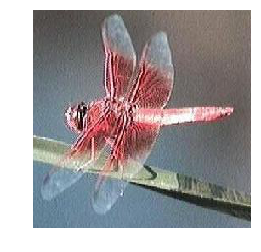

In [42]:
ax, image = imshow_tensor(x)

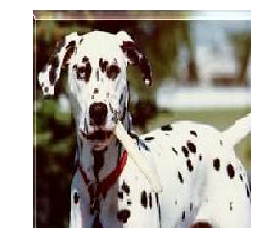

In [43]:
ax, image = imshow_tensor(process_image(testdir + 'dalmatian/image_0053.jpg'))

## Function to make predictions

The next function makes predictions on a single image. It will return the top probabilities and classes. 

In [29]:
def predict(image_path, model, topk=2):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        logits = out.logits
        ps = torch.exp(logits)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

This function can be used to pick a random test image. 

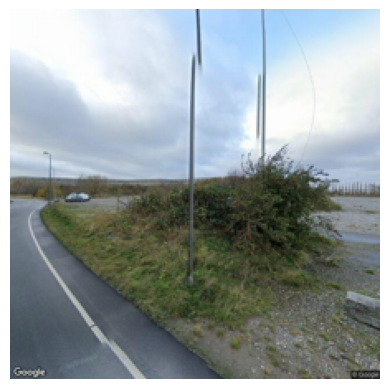

In [27]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [30]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

torch.Size([3, 224, 224])

In [31]:
top_p, top_classes, real_class

(array([4.99113 , 3.045573], dtype=float32),
 ['copenhagen', 'madrid'],
 'madrid')

In [32]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([27.534885,  1.618956], dtype=float32),
 ['moscow', 'copenhagen'],
 'moscow')

### Function to Display Predictions

This function displays the picture along with the `topk` predictions from the model. The title over the image displays the true class.

In [33]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

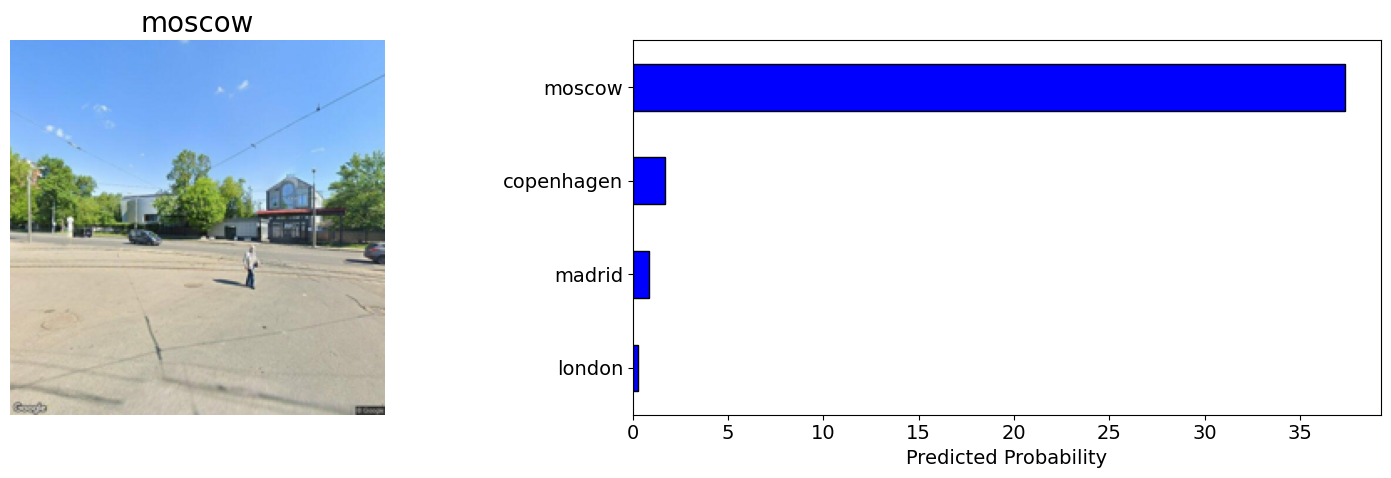

In [34]:
display_prediction(random_test_image(), model, topk=4)

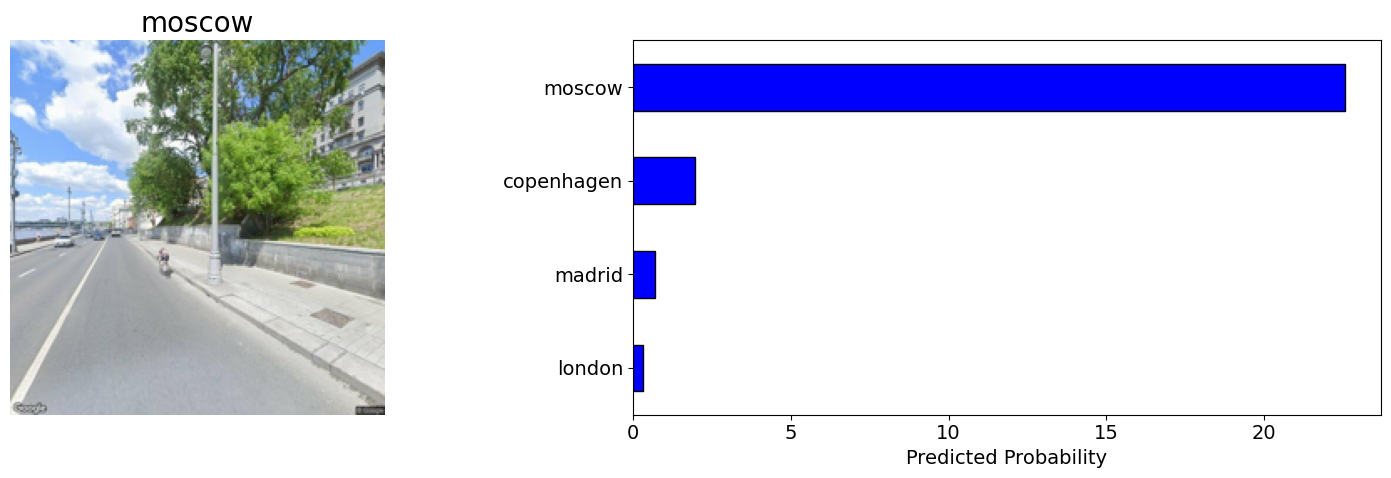

In [40]:
display_prediction(random_test_image(), model, topk=4)

# Testing Accuracy

Image identification models are usually assessed in terms of topk accuracy (for example the vgg16 model gets 28.41% top1 error and 9.62% top5 error on Imagenet). We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 5 actual classes.

The function below computes accuracy for a prediction and a target in terms of topk.

In [42]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [51]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 4))
else:
    accuracy(model(features), targets, topk=(1, 4))

[90.0, 100.0]

## Function to Evaluate Model Over All Classes

The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [52]:
def evaluate(mode, test_loader, criterion, topk=(1,4)):
    """Evaluate the model on the test set

    Params
    --------
        model (PyTorch model): trained model for inference
        test_loader (PyTorch DataLoader): test dataloader
        criterion (PyTorch loss function): loss function
        topk (tuple): topk accuracy to compute

    Returns
    --------
        test_loss (float): average test loss
        test_accuracy (float): average test accuracy
    """
    test_loss = 0.0
    test_accuracy = 0.0

    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.to('cuda'), target.to('cuda')

        output = mode(data)
        loss = criterion(output, target)

        test_loss += loss.item() * data.size(0)

        # Compute accuracy
        acc = accuracy(output, target, topk=topk)
        test_accuracy += acc[0]

    # Average loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_accuracy / len(test_loader)

    return test_loss, test_accuracy

In [53]:
evaluate(model, dataloaders['test'], criterion, topk=(1, 4))

(0.7193414548143225, 65.45454545454545)